# WA Marketing A/B Test

## Table of Contents  <a id='back'></a> 
- [Project Introduction](#project-introduction)
    - [Analysis Outline](#analysis-outline)
    - [Results](#results)
- [Importing Libraries and Opening Data Files](#importing-libraries-and-opening-data-files)
- [Pre-Processing Data](#pre-processing-data)
    - [Data Structure Overhaul](#data-structure-overhaul)
        - [Header Style](#header-style)
        - [Formatting and Data Usage](#formatting-and-data-usage)
    - [Duplicates](#duplicates)
    - [Missing Values](#missing-values)
    - [Removing Irrelevant Data](#removing-irrelevant-data)
- [Data Analysis](#data-analysis)
- [ANOVA Test](#anova-test)
- [Conclusion](#conclusion)
- [Dataset Citation](#dataset-citation)

<a name='headers'>

## Project Introduction

A quick growing fast-food chain is planning to add a new menu and is currently undecided between three possible marketing campaigns for their new product. To find the best marketing campaign for optimal sales growth, the new menu item is introduced to several locations in randomly selected markets. One of three marketing campaigns is randomly used at each location and the weekly total sales will be recorded for the first four weeks under the new campaign. To find the best marketing campaign we are going to conduct an A/B test to statistically find the optimal marketing campaign.

### Analysis Outline

- The ANOVA test was used, and the established hypothesis is:

    - (H0): M0 = M1 = M2 (There is not a statistical difference in the promotion groups)
    
    - (H1): M0 != M1 != M2 (There is a statistical difference in the promotion groups)

- Shapiro-Wilk test resulted in the significance level being less than 0.05, leading us to reject the null hypothesis, indicating that the assumption of equality is not met and that it is not a normal distribution

- In the case of non-normal distribution, we used the Kruskal–Wallis Test a non-parametric test. For this scenario, we are going to use the Kruskal–Wallis Test

- The p-value resulted being less than 0.05 giving reason to reject the null hypothesis showing there is a significant statistical difference in at least one of the promotion groups

- After discovering there is at least one statistical difference in the promotion groups we can now use multiple comparisons to test the null hypothesis that the difference in means of all pairs is 0

### Results

This fast-food company has reason to reject the null hypothesis of adding the new menu items and embrace the alternative hypothesis in keeping the original menu items since they statistically perform better than the new menu items

## Importing Libraries and Opening Data Files

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.stats import shapiro, kruskal
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.pyplot as plt
import seaborn  as sns

In [2]:
# Importing dataset
try:
    mc = pd.read_csv('wa_marketing_campaign.csv')
except:
    mc = pd.read_csv('/datasets/wa_marketing_campaign.csv')

[Back to Table of Contents](#back)

## Pre-Processing Data

### Data Structure Overhaul

In [3]:
# Getting general information about the dataset
mc.info()
mc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


#### Header Style

In [4]:
#checking for snakecase format
mc.columns

Index(['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion',
       'week', 'SalesInThousands'],
      dtype='object')

In [5]:
# Renaming and formatting column names to snake_case format
mc = mc.rename(columns={'MarketID': 'market_id',
                        'MarketSize': 'market_size',
                        'LocationID': 'location_id',
                        'AgeOfStore': 'store_age',
                        'Promotion': 'promotion_group',
                        'SalesInThousands': 'sales_in_thousands'})
mc.columns

Index(['market_id', 'market_size', 'location_id', 'store_age',
       'promotion_group', 'week', 'sales_in_thousands'],
      dtype='object')

[Back to Table of Contents](#back)

#### Formatting and Data Usage

In [6]:
# By using nunique we can find the total number of unique values in each column. Depending
# on the number of unique results we can change the column data types to reduce data usage.
mc.info()
mc.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   market_id           548 non-null    int64  
 1   market_size         548 non-null    object 
 2   location_id         548 non-null    int64  
 3   store_age           548 non-null    int64  
 4   promotion_group     548 non-null    int64  
 5   week                548 non-null    int64  
 6   sales_in_thousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


market_id              10
market_size             3
location_id           137
store_age              25
promotion_group         3
week                    4
sales_in_thousands    517
dtype: int64

In [7]:
mc['market_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [8]:
mc['market_size'].unique()

array(['Medium', 'Small', 'Large'], dtype=object)

In [9]:
# Changing column to snake_case format and changing data type to reduce data usage
mc['market_size'] = mc['market_size'].str.lower()
mc['market_size'] = mc['market_size'].astype('category')

In [10]:
mc['location_id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
       101, 102, 103, 104, 105, 106, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 301, 302, 303, 304, 305, 306, 307, 308, 309, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513,
       514, 515, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611,
       612, 613, 614, 615, 701, 702, 703, 704, 705, 706, 707, 708, 709,
       710, 711, 712, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810,
       901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913,
       914, 915, 916, 917, 918, 919, 920], dtype=int64)

In [11]:
mc['store_age'].unique()

array([ 4,  5, 12,  1, 10, 15,  6, 22,  8, 19, 11, 13,  3,  7,  2, 23,  9,
       28, 25, 14, 24, 18, 27, 17, 20], dtype=int64)

In [12]:
mc['promotion_group'].unique()

array([3, 2, 1], dtype=int64)

In [13]:
mc['promotion_group'] = mc['promotion_group'].astype('category')
mc['promotion_group'] = mc['promotion_group'].replace(1, 'a').replace(2, 'b').replace(3, 'c')

In [14]:
mc['week'].unique()

array([1, 2, 3, 4], dtype=int64)

In [15]:
mc['sales_in_thousands'].unique()

array([33.73, 35.67, 29.03, 39.25, 27.81, 34.67, 27.98, 27.72, 44.54,
       37.94, 45.49, 34.75, 39.28, 39.8 , 24.77, 30.98, 30.37, 24.82,
       37.47, 23.35, 32.9 , 22.18, 42.98, 26.68, 42.92, 42.16, 51.72,
       36.17, 30.08, 28.62, 25.4 , 27.26, 37.41, 38.64, 40.9 , 41.11,
       34.27, 29.3 , 23.93, 35.16, 33.42, 37.93, 33.85, 40.25, 35.85,
       36.24, 41.73, 37.32, 50.48, 36.88, 35.68, 46.45, 67.48, 65.57,
       68.42, 60.93, 61.59, 63.64, 54.68, 61.24, 62.93, 58.77, 70.6 ,
       65.06, 59.76, 66.11, 62.16, 64.04, 59.65, 57.04, 59.73, 56.72,
       58.55, 62.19, 53.14, 62.27, 86.14, 82.56, 79.36, 77.17, 88.73,
       85.21, 81.55, 94.17, 89.7 , 78.43, 84.05, 81.18, 87.43, 81.79,
       88.12, 75.29, 83.02, 90.3 , 85.18, 89.77, 82.64, 82.89, 82.13,
       88.91, 87.7 , 81.16, 81.58, 94.21, 96.48, 84.13, 91.98, 81.72,
       93.71, 96.01, 93.03, 97.61, 85.11, 88.07, 94.43, 89.44, 88.64,
       81.37, 82.14, 79.64, 84.34, 87.9 , 76.12, 82.72, 73.22, 75.88,
       78.01, 80.17,

In [16]:
mc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   market_id           548 non-null    int64   
 1   market_size         548 non-null    category
 2   location_id         548 non-null    int64   
 3   store_age           548 non-null    int64   
 4   promotion_group     548 non-null    category
 5   week                548 non-null    int64   
 6   sales_in_thousands  548 non-null    float64 
dtypes: category(2), float64(1), int64(4)
memory usage: 22.9 KB


[Back to Table of Contents](#back)

### Duplicates

In [17]:
# Checking for duplicates
mc.duplicated().sum()

0

[Back to Table of Contents](#back)

### Missing Values

In [18]:
# Checking for null values
mc.isna().sum()

market_id             0
market_size           0
location_id           0
store_age             0
promotion_group       0
week                  0
sales_in_thousands    0
dtype: int64

[Back to Table of Contents](#back)

### Removing Irrelevant Data

In [19]:
# Removing columns we do not need for this analysis
mc = mc.drop(columns=['market_id', 'location_id', 'store_age', 'week'])
mc.columns

Index(['market_size', 'promotion_group', 'sales_in_thousands'], dtype='object')

[Back to Table of Contents](#back)

## Data Analysis

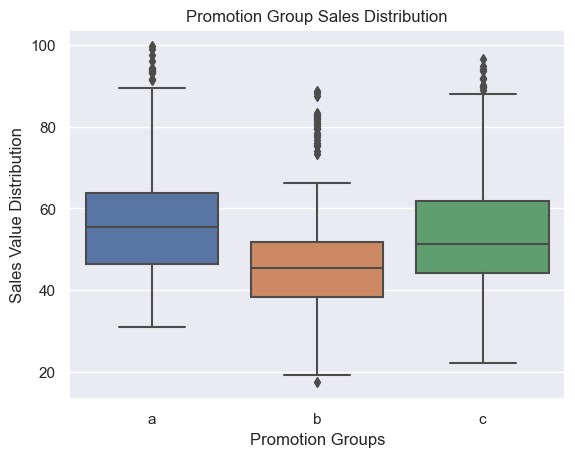

In [21]:
# Setting theme
sns.set_theme(style='darkgrid')

# Looking at the sales distribution
sns.boxplot(data=mc,
            x='promotion_group',
            y='sales_in_thousands')
plt.title('Promotion Group Sales Distribution')
plt.xlabel('Promotion Groups')
plt.ylabel('Sales Value Distribution')
plt.show()

Observation:

- Based on the data, the promotion group B has a lower sales median and range than groups A and C

- Additionally, there are several outliers for each of the promotion groups leading me to believe that they are not normally distributed

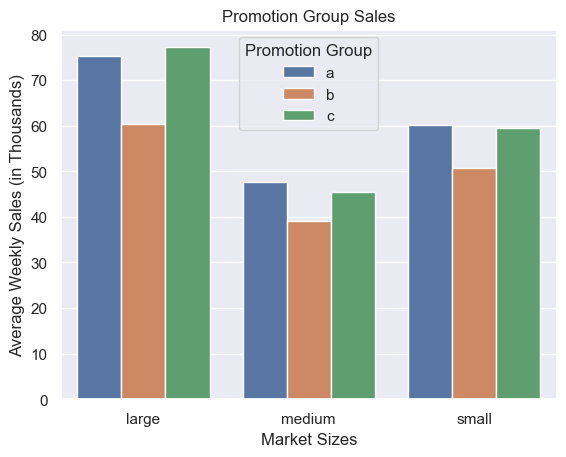

In [ ]:
# Looking at the the sales from the different market sizes and promotion groups
sns.barplot(data=mc,
            x='market_size',
            y='sales_in_thousands',
            hue='promotion_group',
            errorbar=None)
plt.title('Promotion Group Sales')
plt.xlabel('Market Sizes')
plt.ylabel('Average Weekly Sales (in Thousands)')
plt.legend(title='Promotion Group')
plt.show()

Observation:

- The average revenue generated from each market size is similar to each other across all market sizes

-  Promotion B is the lowest-performing marketing campaign across all market sizes

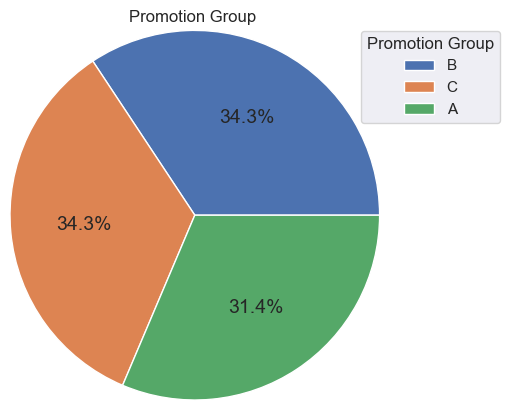

In [ ]:
# Looking for the promotion group distribution
mc['promotion_group'].value_counts().plot(kind='pie',
                                          autopct='%1.1f%%',
                                          fontsize=14,
                                          labels=['', '', ''],
                                          radius=1.25)
plt.title('Promotion Group ',
          loc='center')
plt.ylabel('')
plt.legend(['B', 'C', 'A'],
           title='Promotion Group',
           loc=[0.95,.75])
plt.show()

Observation:

- Promotion group A is about 3% lower than either promotion group B or C 

- This shows that the sample sizes were not equal and breaks the homogeneity of variance assumption

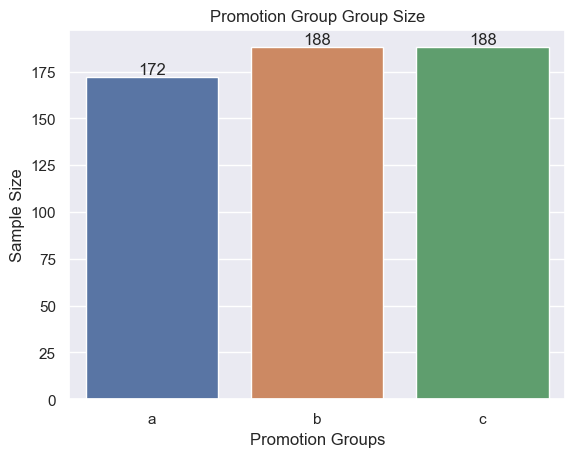

In [ ]:
# Looking at the total participants within each promotion group
ax = sns.countplot(data=mc,
                   x='promotion_group')
plt.bar_label(ax.containers[0])
plt.title('Promotion Group Group Size')
plt.xlabel('Promotion Groups')
plt.ylabel('Sample Size')
plt.show()

Observation:

- Promotion group A has 16 fewer participants than groups B and C breaking the Homogeneity of variance assumption

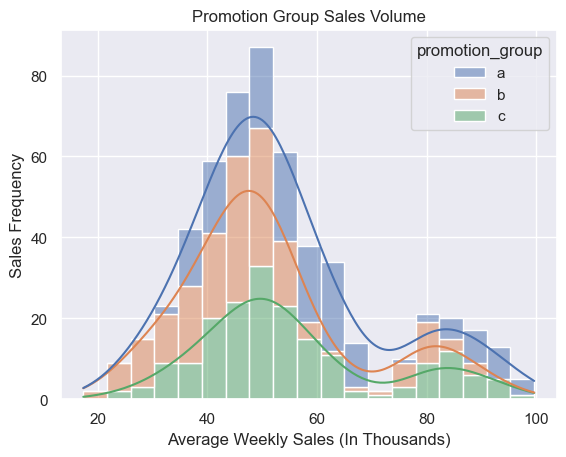

In [ ]:
# Uncovering the sales frequency for each promotion group
sns.histplot(data=mc,
             x='sales_in_thousands',
             hue='promotion_group',
             multiple='stack',
             kde=True)
plt.title('Promotion Group Sales Volume')
plt.xlabel('Average Weekly Sales (In Thousands)')
plt.ylabel('Sales Frequency')
plt.show()

Observation:

- This graphically shows that the data is not normally distributed and would possibly need to use the Kruskal-Wallis test

[Back to Table of Contents](#back)

### ANOVA Test

#### Testing Method Background Info:

In this hypothesis testing, we will use an analysis of variance method, also known as ANOVA testing, which allows us to compare multiple promotion groups (2+). When performing an ANOVA test, we need to make three assumptions:
1)	Samples are randomly selected
2)	Normality of the groups (Must be normally distributed)
3)	Homogeneity of variance (Equal sample sizes)

Depending on if each assumption is met, we can try different tests to see if we can accept or reject the null hypothesis. 

- If the normality assumption is met and we do not reject the null hypothesis we continue to the Homogeneity Test

- If the normality assumption is not met and we reject the null hypothesis then we switch to a non-parametric testing method (Kruskal-Wallis Test)
    
For this test, we will set the significant level of 0.05 indicating that this test has up to a 5% chance to result in the wrong decision. Suppose the calculated p-value is greater than or equal to the significance level. In that case, we can safely assume no statistically significant difference in testing groups and fail to reject the null hypothesis (H0). However, if the calculated p-value is less than the significance level, there is a more significant statistical difference between at least one of the testing groups and we reject the null hypothesis (H0). 
Established null hypothesis:

- If: (H0): M0 = M1 = M2 (There is not a statistical difference in the promotion groups)

    - Then: We fail to reject the null hypothesis and we add the new items to the menu
    
- If: (H1): M0 != M1 != M2 (There is a statistical difference in at least one of the promotion groups)

    - Then: We have reason to reject the null hypothesis and embrace the alternative hypothesis and do not add the new items to the menu



In [ ]:
# Normality Assumption - Shapiro-Wilk Test to test normality of distribution
for group in list(mc['promotion_group'].unique()):
    p_value = shapiro(mc.loc[mc['promotion_group'] == group, 'sales_in_thousands'])[1]
    print(group, 'p-value: %.4f' % p_value)

c p-value: 0.0000
b p-value: 0.0000
a p-value: 0.0000


Observation:

- Since the p-value < 0.05 we have reason to reject the null hypothesis which indicates this is not a normal distribution 

- In cases of a non-normal distribution, we can then use a non-parametric test like the Kruskal–Wallis Test 

In [ ]:
# Non-Parametric Test - Kruskal–Wallis Test
s,p = kruskal(mc.loc[mc['promotion_group']=='a', 'sales_in_thousands'],
              mc.loc[mc['promotion_group']=='b', 'sales_in_thousands'],
              mc.loc[mc['promotion_group']=='c', 'sales_in_thousands'])
print(f'Statistic: {s:.3f}\np-value: {p:.3f}')

Statistic: 53.295
p-value: 0.000


Observation:

- The p-value resulted being less than 0.05 giving reason to reject the null hypothesis showing there is a significant statistical difference in at least one of the promotion groups

- Since there is at least one statistical difference in the promotion groups we can now use multiple comparisons to test the null hypothesis that the difference in means of all pairs is 0

In [ ]:
# Checking for which groups are significantly different - Tukey-Kramer Multiple Comparisons Test
multi_comparison = MultiComparison(mc['sales_in_thousands'], mc['promotion_group'])
tukey = multi_comparison.tukeyhsd(0.05)
print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     a      b -10.7696    0.0 -14.7738 -6.7654   True
     a      c  -2.7345 0.2444  -6.7388  1.2697  False
     b      c   8.0351    0.0   4.1208 11.9493   True
-----------------------------------------------------


Observation:

- Only the group paring A and C has a p-value of greater than 0.05 and shows that there is no significant difference in those marketing groups

- Group parings A and B and parings B and C both resulted in p-values being less than 0.05 which shows a significant difference in marketing groups

- Since there is at least one statistically different marketing campaign, we have reason to reject the null hypothesis and embrace the alternative hypothesis

[Back to Table of Contents](#back)

## Conclusion

ANOVA testing is a useful tool that most businesses can apply to their business strategies to compare various ideas and marketing strategies without completely committing to one or another. Based on the results of this dataset, I uncovered that this fast-food company has reason to reject the null hypothesis of adding the new menu items and embrace the alternative hypothesis in keeping the original menu items since they statistically perform better than the new menu items

[Back to Table of Contents](#back)

## Dataset Citation

Anastasia Chebotina. (2021, May). Fast Food Marketing Campaign A\B Test, Version 1. Retrieved April 23, 2024 from [Kaggle](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test/code).

[Back to Table of Contents](#back)